In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import format_float_scientific as ffs
import sys
sys.path.append("..")
import time as Time
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=5)
device = 'cpu'

In [2]:
%load_ext autoreload
%autoreload 2
from Forward_Parameter import t2, time_span

In [3]:
collocation_points = np.arange(0, t2, time_span)

In [ ]:
from PINN_Save import Save_Loss_forward, Save_PINN_forward
from Forward_Parameter import seed, max_iteration, epsilon, save
from Forward_PINN import Sequentialmodel

filename = "Non-Dim run"

start = Time.time()
torch.manual_seed(seed); np.random.seed(seed) #Fix seed 

#layers = np.array([20,20,20,20,20,20,20,20,2])
layers = np.array([50,50,50,2])
#layers = np.array([1,10,10,2])

PINN = Sequentialmodel(layers, 
                       collocation_points, 
                       config = 'non_dim_mixed2', 
                       reduction = torch.mean,
                       activation = nn.Tanh()).to(device)

params = list(PINN.parameters())
optimizer_BFGS = torch.optim.LBFGS(params, lr=1.0, 
                              max_iter = 1, 
                              max_eval = 100, 
                              tolerance_grad = 1e-20, 
                              tolerance_change = 1e-6 * 1e-6, 
                              history_size = 100, 
                              line_search_fn = "strong_wolfe")



#optimizer_adam = torch.optim.Adam(params, lr=0.001)

PINN.set_optimizer(optimizer_BFGS)


loss_list ={"total":[0], 
            "ini":[], 
            "ode":[], 
            "p": [], 
            "q": [],
            "iter": [],
            "layer_activations": {i+1: [] for i in range(len(layers[1:-1]))}}


for i in range(3000):
    optimizer_BFGS.step(PINN.closure)
    Save_Loss_forward(PINN, loss_list, i, deep=False)
    
    if((loss_list["total"][-1]) < 5e-6):
        break
    
del loss_list["total"][0]

Save_PINN_forward(PINN, filename, loss_list)

end = Time.time()

print("Traininig time = ", end - start, " [s]")

Step: 1 	 Total loss: 2.0192e+00  	 Initial Loss: 7.2879e-01 	  PDE Loss: 1.290363e+00
Step: 2 	 Total loss: 1.4013e+00  	 Initial Loss: 5.9527e-01 	  PDE Loss: 8.060411e-01
Step: 3 	 Total loss: 1.4013e+00  	 Initial Loss: 5.9527e-01 	  PDE Loss: 8.060411e-01
Step: 4 	 Total loss: 2.9870e-01  	 Initial Loss: 1.4207e-01 	  PDE Loss: 1.566342e-01
Step: 5 	 Total loss: 2.9870e-01  	 Initial Loss: 1.4207e-01 	  PDE Loss: 1.566342e-01
Step: 6 	 Total loss: 9.2135e-02  	 Initial Loss: 2.1773e-02 	  PDE Loss: 7.036229e-02
Step: 7 	 Total loss: 9.2135e-02  	 Initial Loss: 2.1773e-02 	  PDE Loss: 7.036229e-02
Step: 8 	 Total loss: 5.6862e-02  	 Initial Loss: 8.0475e-03 	  PDE Loss: 4.881430e-02
Step: 9 	 Total loss: 5.6862e-02  	 Initial Loss: 8.0475e-03 	  PDE Loss: 4.881430e-02
Step: 100 	 Total loss: 6.3409e-04  	 Initial Loss: 2.2501e-06 	  PDE Loss: 6.318402e-04
Step: 200 	 Total loss: 2.8104e-04  	 Initial Loss: 2.0441e-07 	  PDE Loss: 2.808309e-04
Step: 300 	 Total loss: 2.3458e-04  	 I

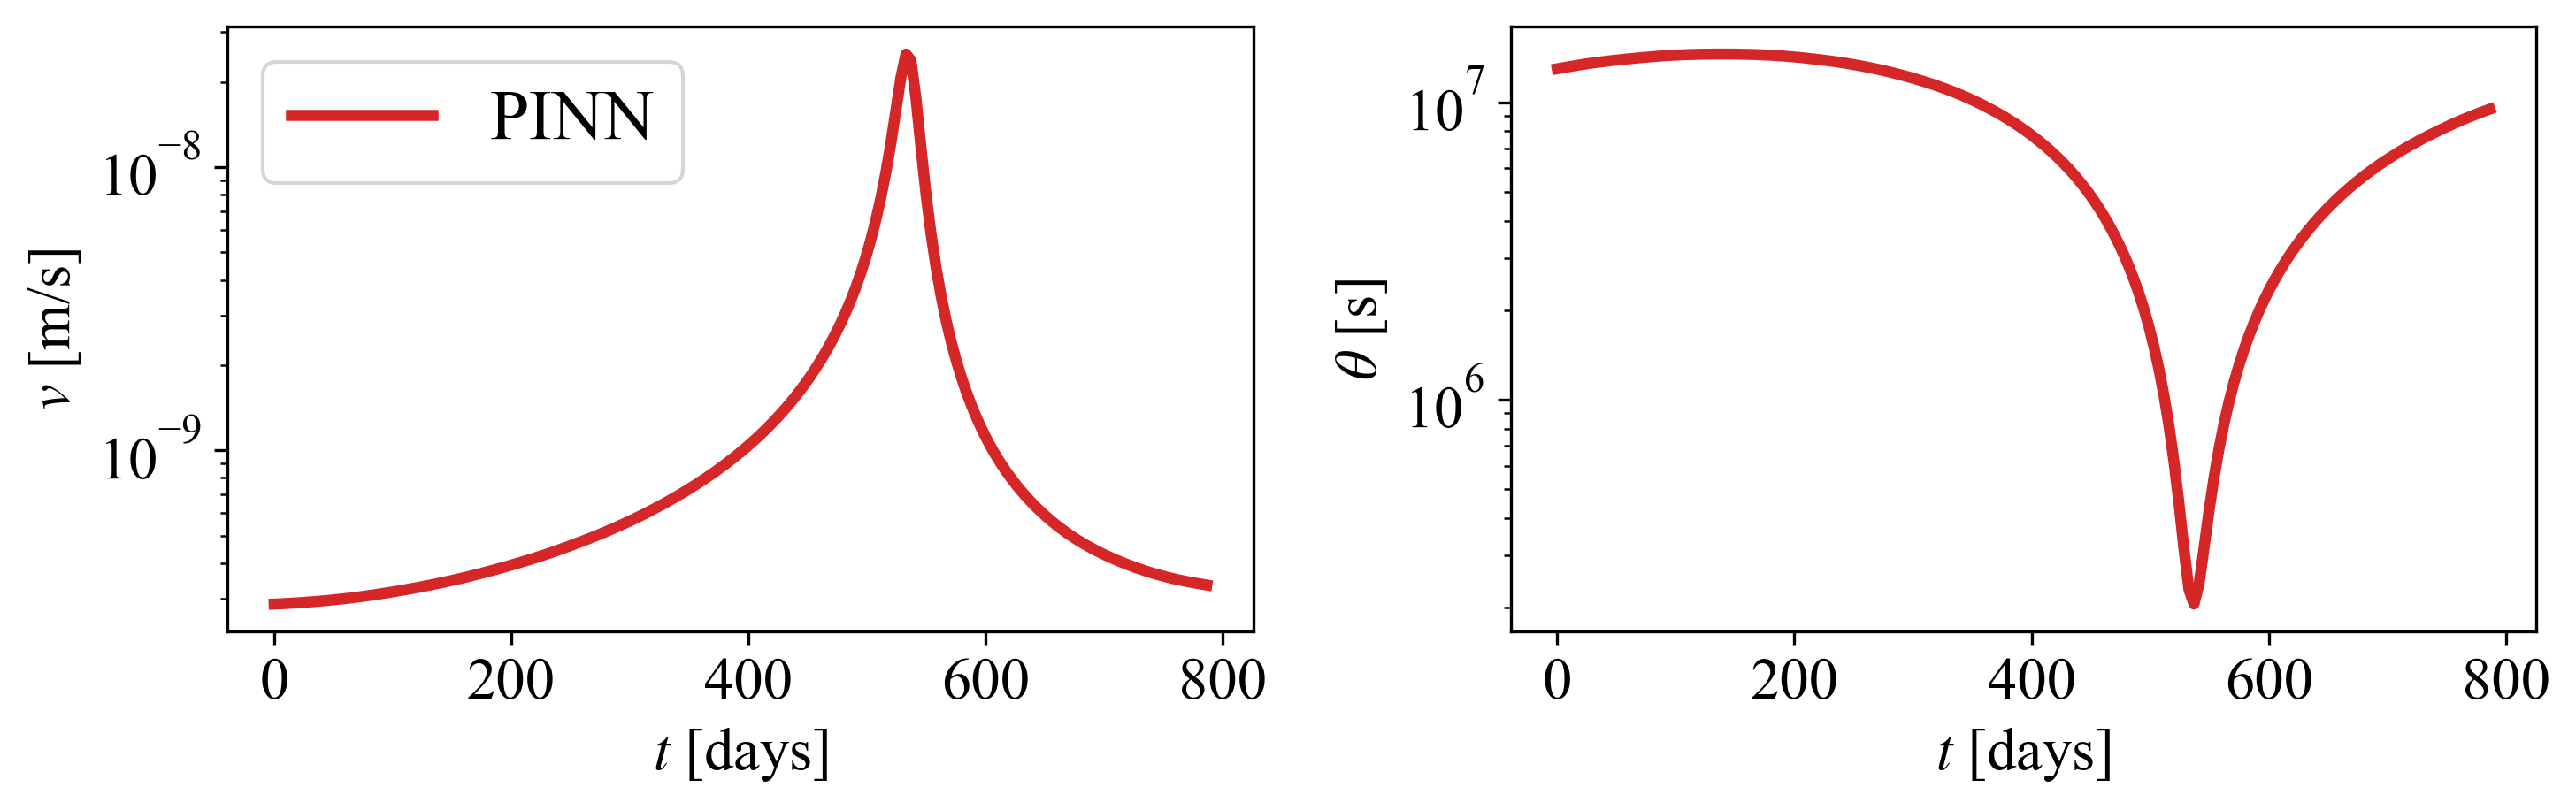

L    :  5.952e-06
Lode :  5.948e-06
Lini :  3.851e-09
Iteration :  3000


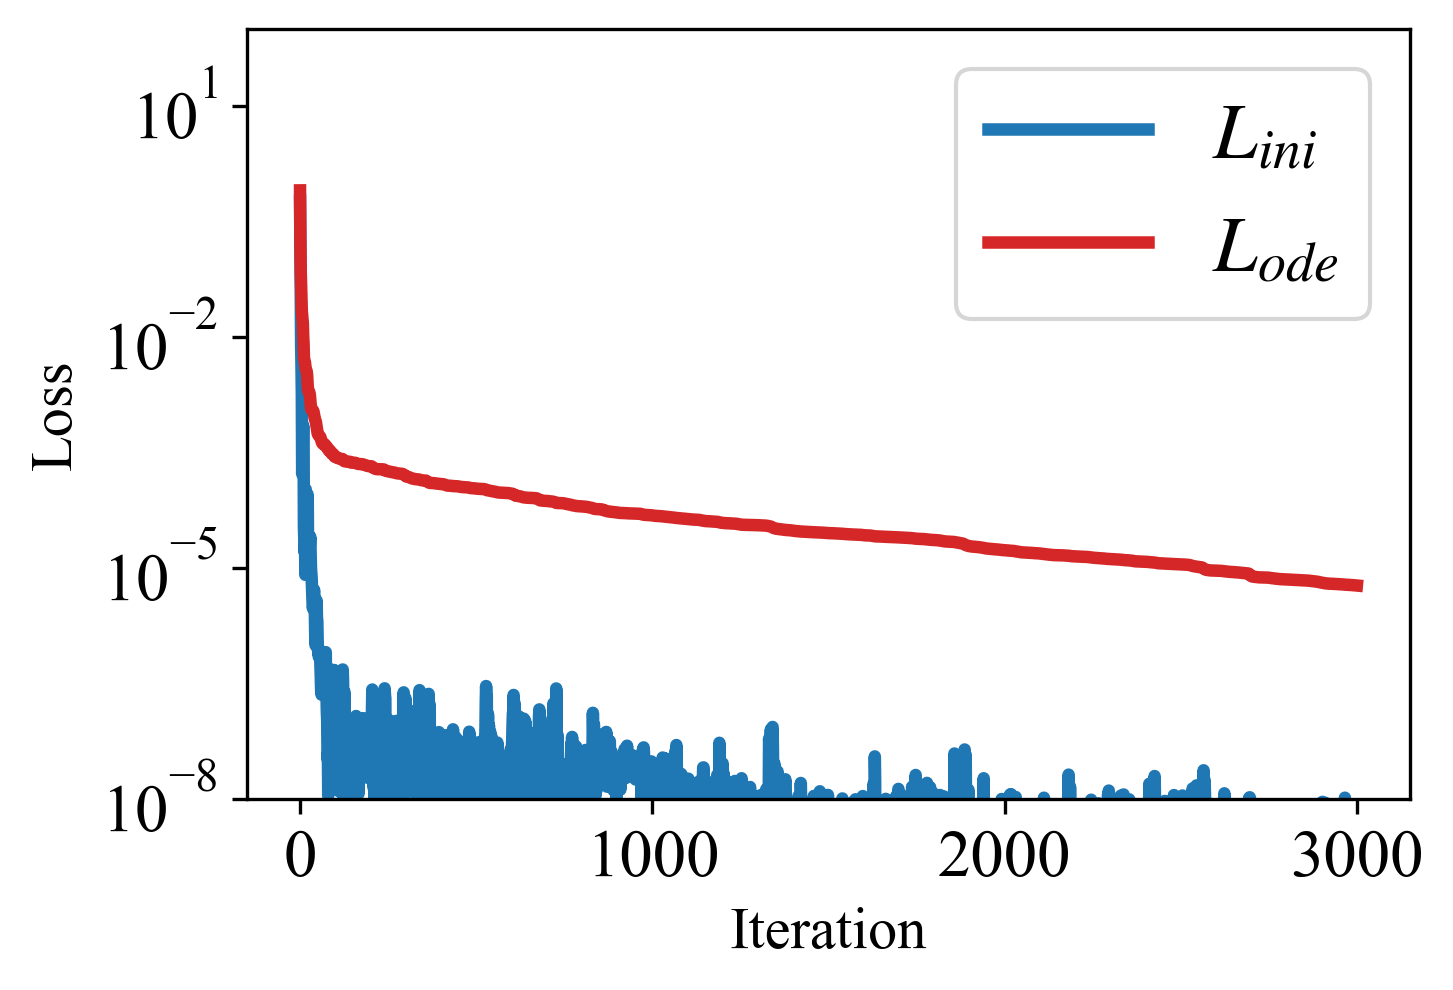

In [115]:
from Forward_Plot import Result
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
Result = Result(PINN, loss_list, filename)
Result.plot_vtheta(save)
Result.plot_loss(save)

In [ ]:
import time as Time
import torch
import numpy as np
from itertools import product
from PINN_Save import Save_Loss_forward, Save_PINN_forward
from Forward_Parameter import seed, max_iteration, epsilon, save
from Forward_PINN import Sequentialmodel

# Set the search space
n_hidden_layers_list = [2, 4, 6, 8]
default_widths = [10, 20, 50, 100, 250, 500]

# Store results
results = []

for n_hidden_layers in n_hidden_layers_list:
    # Restrict widths based on number of layers
    if n_hidden_layers == 8:
        widths = [5, 10, 20, 50, 100]
    elif n_hidden_layers == 6:
        widths = [5, 10, 20, 50, 100, 200]
    else:
        widths = default_widths

    for width in widths:

        torch.manual_seed(seed)
        np.random.seed(seed)

        # Build layer structure: input + hidden layers + output
        layers = [1] + [width] * n_hidden_layers + [2]

        # Initialize model
        PINN = Sequentialmodel(np.array(layers), collocation_points, config='non_dim_mixed2', reduction=torch.mean).to(device)

        # Set optimizer
        optimizer = torch.optim.LBFGS(list(PINN.parameters()), lr=1.0,
                                    max_iter=1,
                                    max_eval=100,
                                    tolerance_grad=1e-20,
                                    tolerance_change=1e-12,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")

        PINN.set_optimizer(optimizer)
        PINN.set_verbose(False)

        # Track losses
        loss_list = {"total": [0], "ini": [], "ode": [], "p": [], "q": [], "iter": []}

        # Start timing
        start = Time.time()

        iterations = 0
        for i in range(2000):
            iterations = i
            optimizer.step(PINN.closure)
            Save_Loss_forward(PINN, loss_list, i)

            if loss_list["total"][-1] < 5e-6:
                break

        end = Time.time()
        training_time = end - start
        combined = iterations * training_time

        # Save results
        results.append({
            "layers": n_hidden_layers
            "width": width,
            "iterations": iterations,
            "time": training_time,
            "combined": combined
        })

        print(f"Layers: {n_hidden_layers} \t Width: {width} \t Iterations: {iterations} \t Time: {training_time:.2f}s \t Final Loss: {loss_list['total'][-1]:.3e}")


Layers: 2 	 Width: 10 	 Iterations: 1999 	 Time: 13.36s 	 Final Loss: 3.032e-04
Layers: 2 	 Width: 20 	 Iterations: 1999 	 Time: 17.89s 	 Final Loss: 3.055e-04
Layers: 2 	 Width: 50 	 Iterations: 1999 	 Time: 21.04s 	 Final Loss: 2.997e-04
Layers: 2 	 Width: 100 	 Iterations: 1999 	 Time: 32.05s 	 Final Loss: 3.038e-04
Layers: 2 	 Width: 250 	 Iterations: 1999 	 Time: 67.16s 	 Final Loss: 3.075e-04
Layers: 2 	 Width: 500 	 Iterations: 1999 	 Time: 159.08s 	 Final Loss: 3.063e-04
Layers: 4 	 Width: 10 	 Iterations: 1999 	 Time: 22.73s 	 Final Loss: 7.009e-05
Layers: 4 	 Width: 20 	 Iterations: 1999 	 Time: 25.01s 	 Final Loss: 3.039e-04
Layers: 4 	 Width: 50 	 Iterations: 1999 	 Time: 31.22s 	 Final Loss: 2.804e-04
Layers: 4 	 Width: 100 	 Iterations: 1999 	 Time: 52.26s 	 Final Loss: 2.298e-04
Layers: 4 	 Width: 250 	 Iterations: 1999 	 Time: 139.67s 	 Final Loss: 2.917e-04
Layers: 4 	 Width: 500 	 Iterations: 1999 	 Time: 728.16s 	 Final Loss: 3.038e-04
Layers: 6 	 Width: 5 	 Iteratio

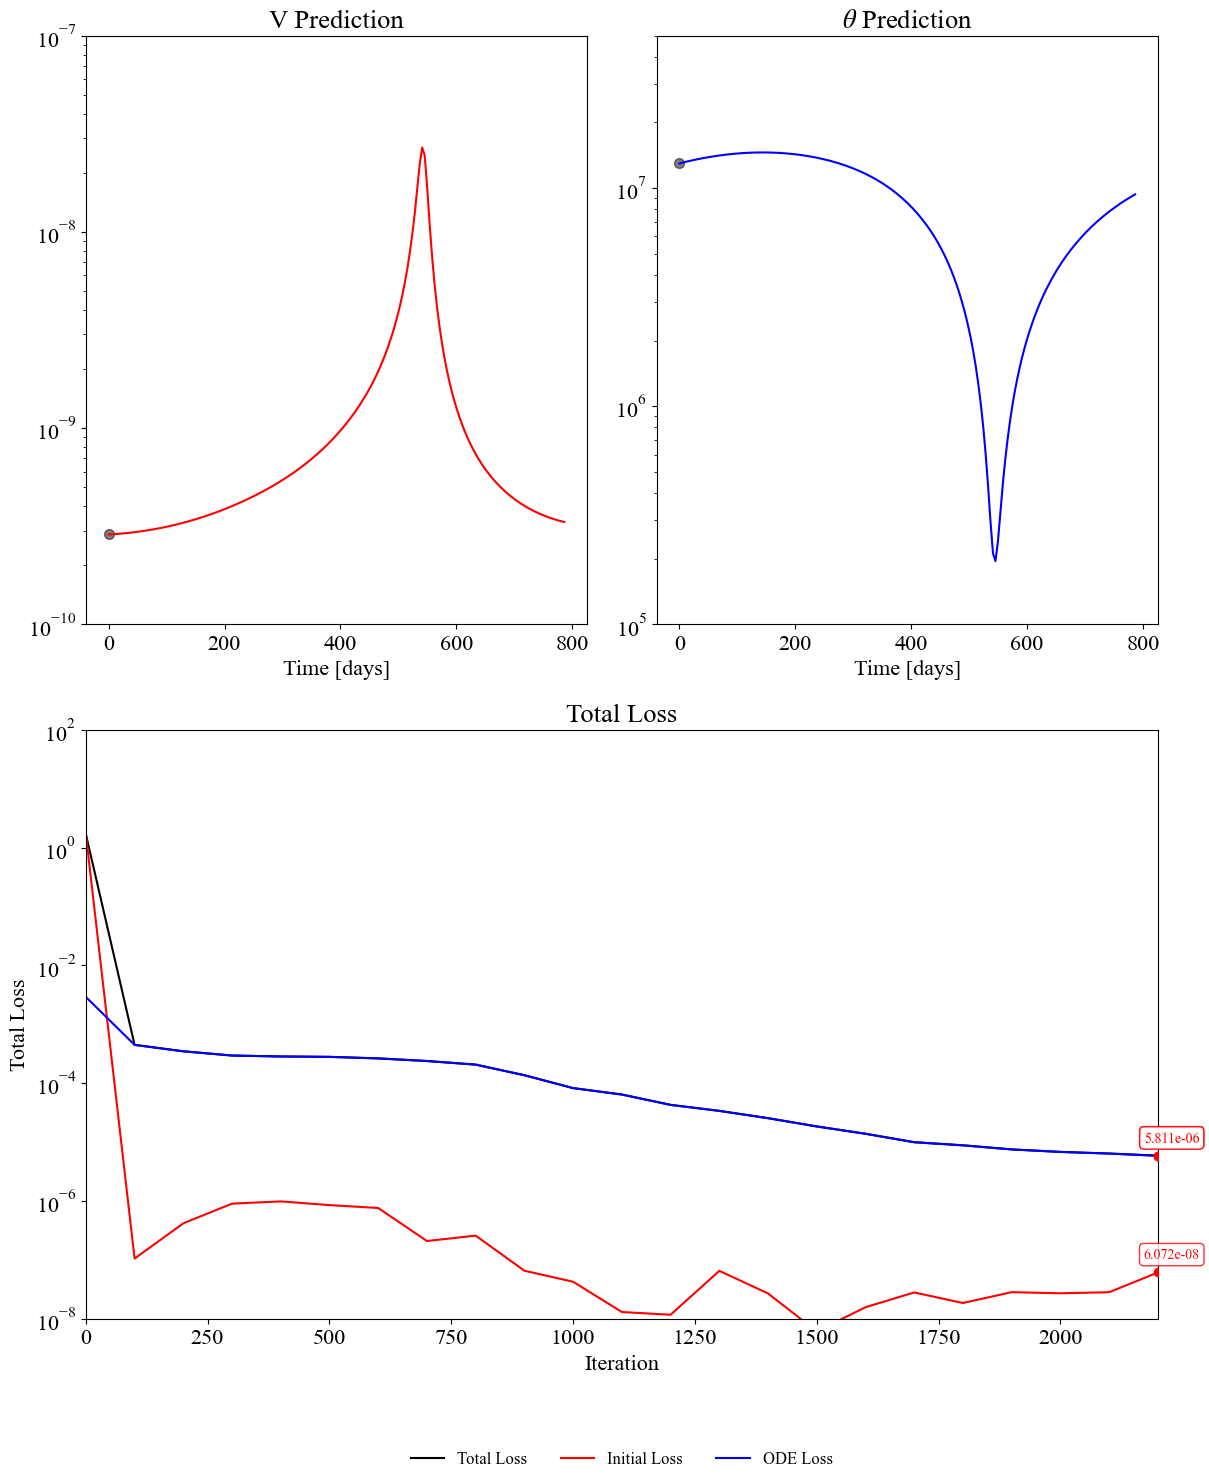

In [95]:
Result.animation_plotSpecial()

In [ ]:
final_output = PINN.forward(PINN.time).detach().numpy()
t_test = PINN.time.detach().numpy()

Result.animate_layer_activations(loss_list, t_test, final_output)

In [ ]:
import time as Time
import torch
import numpy as np
from itertools import product
from PINN_Save import Save_Loss_forward, Save_PINN_forward
from Forward_Parameter import seed, max_iteration, epsilon, save
from Forward_PINN import Sequentialmodel

# Set the search space
n_hidden_layers_list = [2, 4, 6, 8]
default_widths = [10, 20, 50, 100, 250, 500]

# Store results
results = []

for n_hidden_layers in n_hidden_layers_list:
    # Restrict widths based on number of layers
    if n_hidden_layers == 8:
        widths = [5, 10, 20, 50, 100]
    elif n_hidden_layers == 6:
        widths = [5, 10, 20, 50, 100, 200]
    else:
        widths = default_widths

    for width in widths:

        torch.manual_seed(seed)
        np.random.seed(seed)

        # Build layer structure: input + hidden layers + output
        layers = [1] + [width] * n_hidden_layers + [2]

        # Initialize model
        PINN = Sequentialmodel(np.array(layers), collocation_points, config='non_dim_mixed2', reduction=torch.mean).to(device)

        # Set optimizer
        optimizer = torch.optim.LBFGS(list(PINN.parameters()), lr=1.0,
                                    max_iter=1,
                                    max_eval=100,
                                    tolerance_grad=1e-20,
                                    tolerance_change=1e-12,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")

        PINN.set_optimizer(optimizer)
        PINN.set_verbose(False)

        # Track losses
        loss_list = {"total": [0], "ini": [], "ode": [], "p": [], "q": [], "iter": []}

        # Start timing
        start = Time.time()

        iterations = 0
        for i in range(2000):
            iterations = i
            optimizer.step(PINN.closure)
            Save_Loss_forward(PINN, loss_list, i)

            if loss_list["total"][-1] < 5e-6:
                break

        end = Time.time()
        training_time = end - start
        combined = iterations * training_time

        # Save results
        results.append({
            "layers": n_hidden_layers,
            "width": width,
            "iterations": iterations,
            "time": training_time,
            "combined": combined
        })

        print(f"Layers: {n_hidden_layers} \t Width: {width} \t Iterations: {iterations} \t Time: {training_time:.2f}s \t Final Loss: {loss_list['total'][-1]:.3e}")


In [ ]:
best = min(results, key=lambda x: x["combined"])
print("\nBest configuration:")
print(f"  Layers: {best['layers']}")
print(f"  Width: {best['width']}")
print(f"  Iterations: {best['iterations']}")
print(f"  Time: {best['time']:.2f}s")
print(f"  Score: {best['combined']:.2f}")